In [1]:
import cv2
import pickle
import numpy as np
import pylab as plt

IMAGE_SIZE = (224, 224)

images = []
masks = []
graphs = []

for i in range(1000):
    try:
        graph = pickle.load(open(f'../data/Vegas/tile_{i}_graph.pickle', 'rb'))
        image = cv2.resize(cv2.imread(f'../data/Vegas/tile_{i}_8bit.tif'), IMAGE_SIZE)
        mask = cv2.resize(cv2.imread(f'../data/Vegas/tile_{i}_mask.tif', cv2.IMREAD_GRAYSCALE), IMAGE_SIZE)
    except Exception as e:
        print(e)
    else:
        graphs.append(graph)
        images.append(image)
        masks.append(np.where(mask == 150, 1.0, 0.0))

[Errno 2] No such file or directory: '../data/Vegas/tile_112_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_174_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_356_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_390_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_428_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_635_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_752_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_849_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_989_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_990_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_991_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_992_graph.pickle'
[Errno 2] No such file or directory: '../data/Vegas/tile_993_graph.pickle'
[Errno 2] No such file or

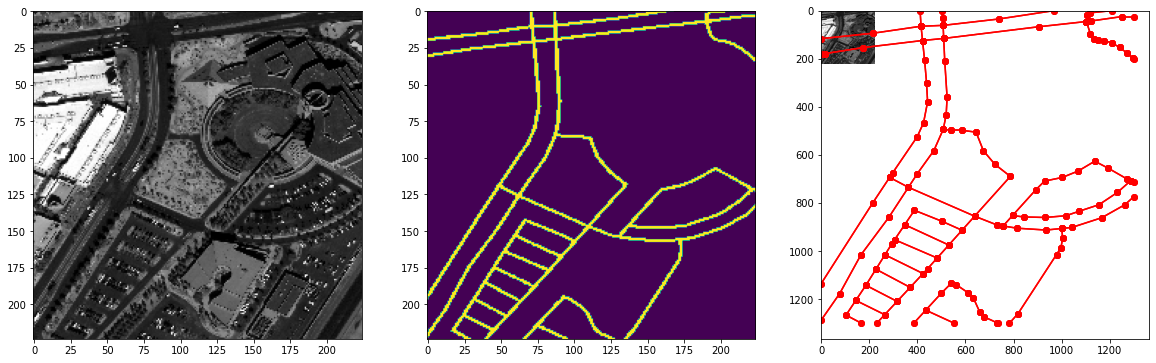

In [2]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(images[0])
ax[1].imshow(masks[0])
ax[2].imshow(images[0])

for u, neighbours in graphs[0].items():
    for v in neighbours:
        ax[2].plot([u[0], v[0]], [u[1], v[1]], 'r')
        ax[2].scatter([u[0], v[0]], [u[1], v[1]], color='r')

In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [4]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

2022-03-27 17:03:00.788656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 17:03:01.371432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13583 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:8b:00.0, compute capability: 7.5


In [5]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [6]:
def unet_model():
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
        padding='same', activation='sigmoid')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [7]:
model = unet_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
images = np.array(images)
masks = np.array(masks)

In [9]:
model.fit(x=images, y=masks, batch_size=16, epochs=10, validation_split=0.1)

Epoch 1/10


2022-03-27 17:03:05.555730: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-03-27 17:03:05.984884: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


56/56 [==============================] - 11s 113ms/step - loss: 77.1082 - accuracy: 0.5941 - val_loss: 73.7675 - val_accuracy: 0.9322
Epoch 2/10
56/56 [==============================] - 5s 85ms/step - loss: 71.6786 - accuracy: 0.9124 - val_loss: 73.3696 - val_accuracy: 0.9344
Epoch 3/10
56/56 [==============================] - 5s 85ms/step - loss: 70.5666 - accuracy: 0.9252 - val_loss: 71.3238 - val_accuracy: 0.9360
Epoch 4/10
56/56 [==============================] - 5s 85ms/step - loss: 70.0247 - accuracy: 0.9311 - val_loss: 71.2926 - val_accuracy: 0.9369
Epoch 5/10
56/56 [==============================] - 5s 85ms/step - loss: 69.5384 - accuracy: 0.9346 - val_loss: 69.9962 - val_accuracy: 0.9382
Epoch 6/10
56/56 [==============================] - 5s 85ms/step - loss: 69.2130 - accuracy: 0.9365 - val_loss: 69.2858 - val_accuracy: 0.9370
Epoch 7/10
56/56 [==============================] - 5s 86ms/step - loss: 68.9115 - accuracy: 0.9370 - val_loss: 69.4103 - val_accuracy: 0.9394
Epoch 8/

In [10]:
images[0].shape

(224, 224, 3)

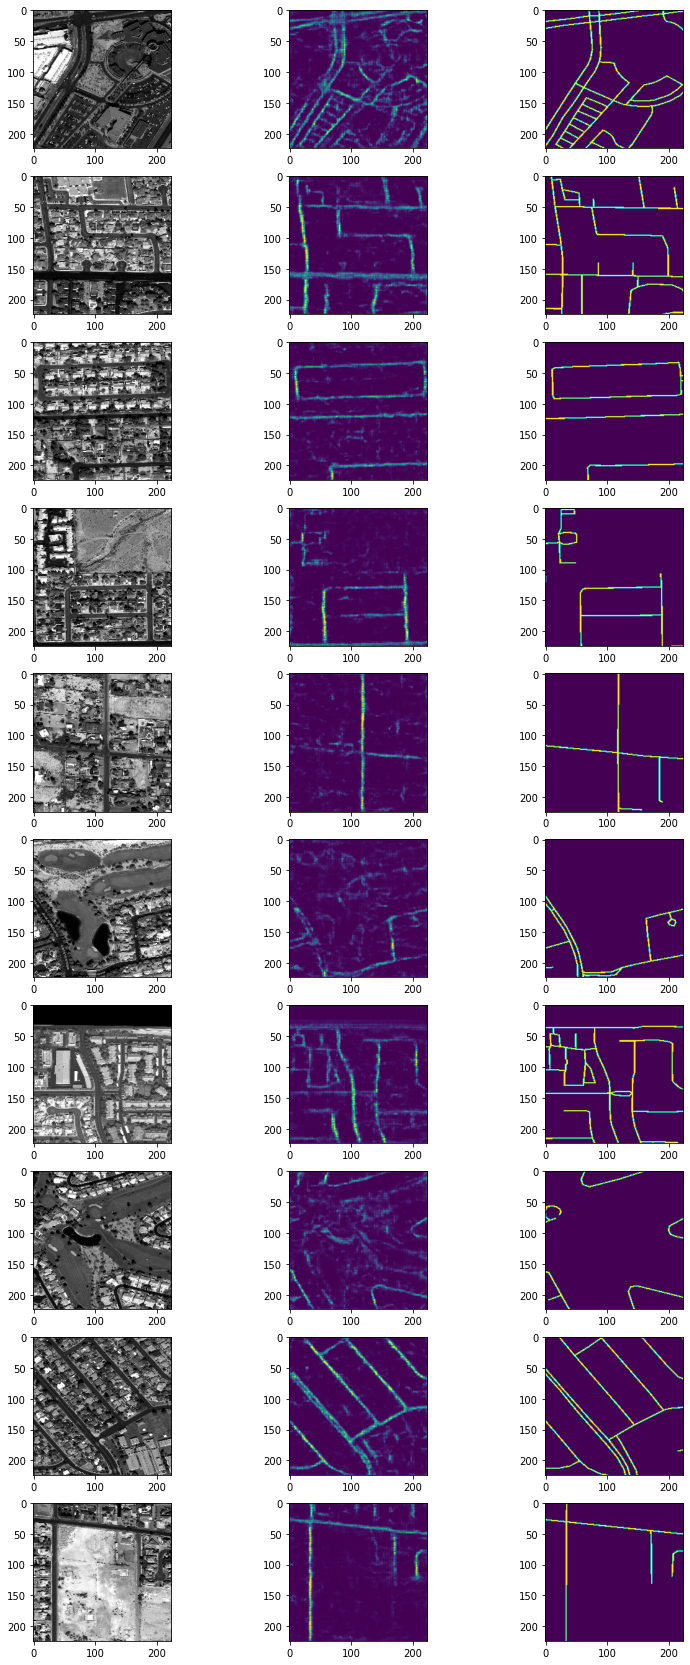

In [15]:
pred_masks = model.predict(images[:10])

fig, ax = plt.subplots(10, 3, figsize=(13, 30))

for i in range(10):
    ax[i, 0].imshow(images[i])
    ax[i, 1].imshow(pred_masks[i])
    ax[i, 2].imshow(masks[i])